In [1]:
import glob
import torch
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from dataset.cityscapes import *
from dataset.transforms import * 
from dataset.utils import *
import torch
from torch import nn
from torch.utils.data import DataLoader
import time
import argparse
from progress.bar import IncrementalBar
from dataset import Cityscapes
from dataset import transforms as T
from gan.generator3 import Generator
from gan.discriminator3 import Discriminator
from gan.criterion import GeneratorLoss, DiscriminatorLoss
from gan.utils import *
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

In [2]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Code runs in {device}")

Code runs in cuda:0


In [3]:
# Hyperparameters
epochs = 200
batch_size = 1
lr = 0.0002
save_image_interval = 2

In [4]:
#transforms = T.Compose([T.ToTensor()])


transforms = T.Compose([#T.HorizontalFlip(),
                        #T.CustomColorJitter(),
                        T.ToTensor(),
                        #T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                        ])      

cityscapes = Cityscapes(transform=transforms)
train_set, val_set, test_set = cityscapes.divide_into_sets()


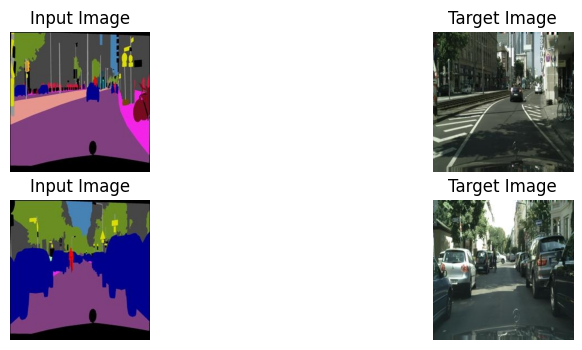

In [5]:
# Assuming 'train_set' is already defined and loaded
visualize_samples(train_set, num_samples=2)

In [6]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
# models
print('Defining models!')
generator = Generator().to(device)
discriminator = Discriminator().to(device)
# optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
# loss functions
g_criterion = GeneratorLoss(alpha=100)
d_criterion = DiscriminatorLoss()

Defining models!


/home/martin/miniconda3/envs/cv2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martin/miniconda3/envs/cv2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/martin/miniconda3/envs/cv2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMA

In [8]:
ssim_metric = SSIM(data_range=1.0).to(device)

In [9]:
print('Start of training process!')
logger = Logger(filename='cityscapes_dataset')

# Training Loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    train_g_loss = 0.0
    train_d_loss = 0.0
    start = time.time()
    bar = IncrementalBar(f'[Epoch {epoch+1}/{epochs}]', max=len(train_loader))
    train_ssim_values = []

    for i, (x, real) in enumerate(train_loader):
        x = x.to(device)
        real = real.to(device)

        # Train Discriminator
        fake = generator(x)
        d_real_pred = discriminator(real, x)
        d_fake_pred = discriminator(fake.detach(), x)
        d_loss = d_criterion(d_real_pred, d_fake_pred)

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_fake_pred = discriminator(fake, x)
        g_loss = g_criterion(fake, real, g_fake_pred)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        train_g_loss += g_loss.item()
        train_d_loss += d_loss.item()
        bar.next()

        ssim = ssim_metric(fake, real)
        train_ssim_values.append(ssim.item())
        # Save generated images periodically
        if (epoch % save_image_interval == 0):  # Adjust as necessary
            save_sample(logger,convert2_0_1(real), convert2_0_1(fake), epoch, i)
    
    train_avg_ssim = sum(train_ssim_values) / len(train_ssim_values)

    bar.finish()
    train_g_loss /= len(train_loader)
    train_d_loss /= len(train_loader)

    # Validation Loop
    generator.eval()
    discriminator.eval()
    val_g_loss = 0.0
    val_d_loss = 0.0
    val_ssim_values = []
    with torch.no_grad():
        for x, real in val_loader:
            x = x.to(device)
            real = real.to(device)
            fake = generator(x)
            d_real_pred = discriminator(real, x)
            d_fake_pred = discriminator(fake, x)
            val_d_loss += d_criterion(d_real_pred, d_fake_pred).item()
            g_fake_pred = discriminator(fake, x)
            val_g_loss += g_criterion(fake, real, g_fake_pred).item()
            ssim = ssim_metric(fake, real)
            val_ssim_values.append(ssim.item())

    val_avg_ssim = sum(val_ssim_values) / len(val_ssim_values)
    val_g_loss /= len(val_loader)
    val_d_loss /= len(val_loader)

    # Logging
    logger.add_scalar('train_generator_loss', train_g_loss, epoch+1)
    logger.add_scalar('train_discriminator_loss', train_d_loss, epoch+1)
    logger.add_scalar('val_generator_loss', val_g_loss, epoch+1)
    logger.add_scalar('val_discriminator_loss', val_d_loss, epoch+1)
    logger.update()

    print(f"[Epoch {epoch+1}/{epochs}] Train G loss: {train_g_loss:.3f} Train D loss: {train_d_loss:.3f} Train SSIM: {train_avg_ssim:.3f} Val G loss: {val_g_loss:.3f} Val D loss: {val_d_loss:.3f} Val SSIM: {val_avg_ssim:.3f}")

    # Save model weights
    if (epoch + 1) % 10 == 0:
        logger.save_weights(generator.state_dict(), f'generator_epoch_{epoch+1}')
        logger.save_weights(discriminator.state_dict(), f'discriminator_epoch_{epoch+1}')



logger.close()
print('End of training process!')

Start of training process!
[Epoch 1/200] Train G loss: 11.715 Train D loss: 0.645 Train SSIM: 0.507 Val G loss: 11.361 Val D loss: 0.693 Val SSIM: 0.524
[Epoch 2/200] Train G loss: 10.693 Train D loss: 0.693 Train SSIM: 0.532 Val G loss: 11.222 Val D loss: 0.693 Val SSIM: 0.522
[Epoch 3/200] Train G loss: 10.211 Train D loss: 0.693 Train SSIM: 0.539 Val G loss: 10.897 Val D loss: 0.693 Val SSIM: 0.525
[Epoch 4/200] Train G loss: 9.862 Train D loss: 0.693 Train SSIM: 0.543 Val G loss: 11.800 Val D loss: 0.693 Val SSIM: 0.512
[Epoch 5/200] Train G loss: 9.653 Train D loss: 0.693 Train SSIM: 0.545 Val G loss: 11.470 Val D loss: 0.693 Val SSIM: 0.525
[Epoch 6/200] Train G loss: 9.228 Train D loss: 0.693 Train SSIM: 0.550 Val G loss: 10.713 Val D loss: 0.693 Val SSIM: 0.532
[Epoch 7/200] Train G loss: 8.917 Train D loss: 0.693 Train SSIM: 0.553 Val G loss: 11.047 Val D loss: 0.693 Val SSIM: 0.526
[Epoch 8/200] Train G loss: 8.627 Train D loss: 0.693 Train SSIM: 0.555 Val G loss: 10.856 Val 

In [10]:
# Evaluate the model in test set
generator.eval()  # Set the generator in validation mode
discriminator.eval()  # set the discriminator in validation mode (if needed)
test_g_loss = 0.0
test_d_loss = 0.0
test_ssim_values = []
i=0
# Initialize the calculation of the metrics with torch.no_grad() to avoid calculating gradients
with torch.no_grad():
    for x, real in test_loader:
        x = x.to(device)
        real = real.to(device)
        
        # Generate images with the generator
        fake = generator(x)
        
        # Calculate the predictions of the discriminator
        d_real_pred = discriminator(real, x)
        d_fake_pred = discriminator(fake, x)
        
        # Calculate the loss of the discriminator
        test_d_loss += d_criterion(d_real_pred, d_fake_pred).item()
        
        # Calculate the loss of the generator
        g_fake_pred = discriminator(fake, x)
        test_g_loss += g_criterion(fake, real, g_fake_pred).item()
        
        # Calculate SSIM
        ssim = ssim_metric(fake, real)
        test_ssim_values.append(ssim.item())

        save_sample(logger,convert2_0_1(real), convert2_0_1(fake), 1, i, prefix='test')
        i+=1

# Calculate the averages of the metrics
test_g_loss /= len(test_loader)
test_d_loss /= len(test_loader)
test_avg_ssim = sum(test_ssim_values) / len(test_ssim_values)

# Show the results of the evaluation on the test set
print(f"Test Results: Test G loss: {test_g_loss:.3f}, Test D loss: {test_d_loss:.3f}, Test SSIM: {test_avg_ssim:.3f}")

# If you have a logger, you can also log the results of the test set evaluation
logger.add_scalar('test_generator_loss', test_g_loss, epoch+1)
logger.add_scalar('test_discriminator_loss', test_d_loss, epoch+1)
logger.add_scalar('test_ssim', test_avg_ssim, epoch+1)


Test Results: Test G loss: 11.553, Test D loss: 0.813, Test SSIM: 0.505
